In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import pandas as pd
import cv2
import sys
from skimage import io
from pycocotools.coco import COCO
from sklearn.preprocessing import MinMaxScaler
from lapsolver import solve_dense
from numba import njit
from numpy.linalg import norm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline
tqdm.pandas()

### Load the DataFrame

In [2]:
path = "../data/2017/captions.json"
data = json.load(open(path, 'r'))
df = pd.DataFrame.from_records(data['images'])
df.drop(columns=['file_name', 'license', 'date_captured', 'flickr_url'], inplace=True)

In [3]:
print(f'We have {len(df)} images')
df.head()

We have 5000 images


,coco_url,height,id,width
0,http://images.cocodataset.org/val2017/00000039...,427,397133,640
1,http://images.cocodataset.org/val2017/00000003...,230,37777,352
2,http://images.cocodataset.org/val2017/00000025...,428,252219,640
3,http://images.cocodataset.org/val2017/00000008...,480,87038,640
4,http://images.cocodataset.org/val2017/00000017...,388,174482,640


### Reduce the DataFrame to square-like images

In [6]:
cond1 = df['height'] < 0.8*df['width']
cond2 = df['height'] > 0.6*df['width']
df = df[cond1 & cond2]

In [7]:
print(f'We now have {len(df)} images')
df.head()

We now have 3242 images


,coco_url,height,id,width
0,http://images.cocodataset.org/val2017/00000039...,427,397133,640
1,http://images.cocodataset.org/val2017/00000003...,230,37777,352
2,http://images.cocodataset.org/val2017/00000025...,428,252219,640
3,http://images.cocodataset.org/val2017/00000008...,480,87038,640
4,http://images.cocodataset.org/val2017/00000017...,388,174482,640


### Load the BERT model

In [8]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

### Use the BERT model to create caption embeddings

In [11]:
def get_caption_embeddings(image_id):
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
    captions = [i['caption'] for i in annotations]
    embeddings = model.encode(captions)
    return embeddings

In [12]:
coco = COCO(path)
df['embeddings'] = df['id'].progress_apply(lambda x: get_caption_embeddings(x))
df['id']

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [13]:
df.to_csv('../data/2017/captions.csv', index=False)

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv('../data/2017/captions.csv')

In [14]:
df.head()

,coco_url,height,id,width,embeddings
0,http://images.cocodataset.org/val2017/00000039...,427,397133,640,"[[0.038188063, 0.88823956, 0.18122429, -0.7679..."
1,http://images.cocodataset.org/val2017/00000003...,230,37777,352,"[[0.18552284, 0.3784791, -0.15212953, 0.089769..."
2,http://images.cocodataset.org/val2017/00000025...,428,252219,640,"[[0.4061236, -0.84412116, 1.0979357, -0.176296..."
3,http://images.cocodataset.org/val2017/00000008...,480,87038,640,"[[0.038959112, -1.12945, 0.93626696, 0.6006372..."
4,http://images.cocodataset.org/val2017/00000017...,388,174482,640,"[[0.2355992, -0.65056777, -1.8893455, -0.06392..."


### Load the images from their URLs and save them locally

In [15]:
def load_and_resize_images(h):
    """h is the height of the resized images"""
    urls = list(df['coco_url'])
    for i, url in enumerate(tqdm(urls)):    
        img = np.float32(io.imread(url))
        w = int(round(h * (img.shape[1]/img.shape[0])))

        flip_img = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_AREA)
        final_img = cv2.cvtColor(flip_img, cv2.COLOR_RGB2BGR)

        path = f'../../static/pictures/{i}.jpg'
        cv2.imwrite(path, final_img)

In [16]:
load_and_resize_images(h=180)

### Calculate the Earth mover's distance (EMD) between the embeddings

In [22]:
@njit
def cosine_similarity(u, v):
    return np.dot(u, v)/(norm(u)*norm(v))

@njit(fastmath=True)
def calculate_dist_matrix(a, b):
    mat = np.zeros(shape=(a.shape[0], b.shape[0]), dtype=np.float32)
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            mat[i][j] = cosine_similarity(a[i], b[j])
    return mat

@njit(fastmath=True)
def numba_mean(arr):
    total = 0
    for a in arr:
        total += a
    return total/arr.shape[0]

def earthmover(a, b):
    dist_matrix = calculate_dist_matrix(a, b)
    assignment = solve_dense(dist_matrix)
    score = numba_mean(dist_matrix[assignment])
    return score

def create_ids_to_score(embeddings):
    N = len(embeddings)
    ids_to_score = np.zeros(shape=(N, N), dtype=np.float16) 
    for i in tqdm(range(N)):
        for j in range(i+1, N):
            score = earthmover(np.array(embeddings[i]), np.array(embeddings[j]))
            ids_to_score[i][j] = score
            ids_to_score[j][i] = score
    return ids_to_score

In [25]:
ids_to_score = create_ids_to_score(df['embeddings'].values)

### Scale the distances to the range 0 to 100

In [26]:
scaler = MinMaxScaler(feature_range=(0, 100))
ids_to_score = scaler.fit_transform(ids_to_score)
print(ids_to_score[:5])

c:\users\peter\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


[[14.56  74.9   28.88  ... 19.73  17.98  55.7  ]
 [71.4   12.484 24.75  ... 13.42  22.06  70.   ]
 [29.34  25.1   10.445 ... 23.72  21.5   30.58 ]
 [26.58  18.47  36.06  ... 31.73  29.03  18.88 ]
 [18.7   25.    53.44  ... 11.28  16.19  32.66 ]]


### Save the ids_to_score array

In [27]:
arr_size = sys.getsizeof(ids_to_score) / (1024**2)
print(f'ids_to_score is of size {arr_size:.2f} MB')

ids_to_score is of size 20.05 MB


In [28]:
np.save('ids_to_score.npy', ids_to_score)

In [ ]:
ids_to_score = np.load('ids_to_score.npy')

### Find the closest picture to the given id

Best score: 100


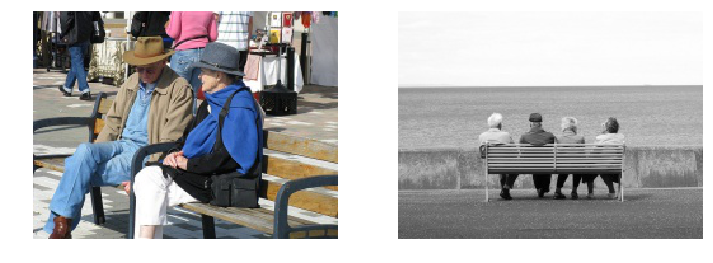

In [52]:
def calculate_closest_id(idx):
    possible_ids = list(range(ids_to_score.shape[0]))
    possible_ids.remove(idx)
    scores = np.array([(i, ids_to_score[idx][i]) for i in possible_ids])
    
    closest_id, best_score = max(scores, key=lambda x: x[1])
    print(f'Best score: {int(best_score)}')
    return int(closest_id)

random_id = np.random.choice(list(range(ids_to_score.shape[0])))
closest_id = calculate_closest_id(random_id)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, idx in enumerate([random_id, closest_id]):
    path = f'../../static/pictures/{idx}.jpg'
    img = io.imread(path)
    ax[i].imshow(img)
    ax[i].axis('off')

### Show the picture and the caption of a given index

['Several different pieces of electronic equipment and computers on a desk.', 'A desk with two laptops and a monitor.', 'Two laptops,computer,keyboard and other electrical gadgets are on the table.', 'two laptops a mouse cords wires and a monitor ', 'Several laptop computers and electronic devices on a desk.']


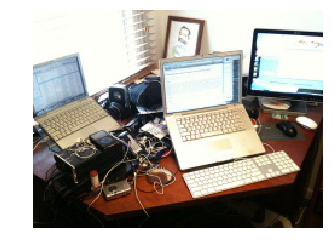

In [48]:
def show_picture(idx):
    path = f'../../static/pictures/{idx}.jpg'
    img = io.imread(path)
    plt.imshow(img)
    plt.axis('off')
    
    _id = list(df['id'])[idx]
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=_id))
    captions = [i['caption'] for i in annotations]
    print(captions)

show_picture(100)